In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from xgboost import XGBClassifier, plot_importance
import xgboost as xgb

import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as pc

In [2]:
import time
from functools import wraps

def timeit(func):
    """
    Decorator that measures and prints the execution time of the decorated function.
    
    Args:
        func (callable): The function to be decorated.
    
    Returns:
        callable: The wrapped function with timing functionality.
    """
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()  # Start timer
        result = func(*args, **kwargs)    # Execute the function
        end_time = time.perf_counter()    # End timer
        elapsed_time = end_time - start_time
        print(f"🔹 Function '{func.__name__}' executed in {elapsed_time:.4f} seconds")
        return result

    return wrapper

In [3]:
@timeit
def load_data(project_path: str) -> pd.DataFrame:
    """
    Load network intrusion detection datasets from multiple days and concatenate them into a single DataFrame.
    
    Parameters:
    - project_path (str): The root directory of the project.
    
    Returns:
    - pd.DataFrame: Concatenated DataFrame containing data from all specified days.
    """
    print('1. Loading Data...')
    days = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday']
    tables = []

    data_dir = os.path.join(project_path, 'data', 'cicids2017')

    for day in days:
        file_path = os.path.join(data_dir, f'{day}.parquet')
        print(f"   Loading data for {day}: {file_path}")
        try:
            table = pq.read_table(file_path)
            tables.append(table)
            print(f"   Successfully loaded {table.num_rows} records for {day}.")
        except FileNotFoundError:
            print(f"   File not found: {file_path}. Skipping {day}.")
        except Exception as e:
            print(f"   Error loading {file_path}: {e}. Skipping {day}.")

    if not tables:
        raise ValueError("No data files were loaded. Please check the file paths and existence.")

    # Concatenate all tables into one
    full_table = pa.concat_tables(tables, promote=True)
    print(f"   Total records loaded: {full_table.num_rows}")
    print(f"   Columns in dataset: {full_table.schema.names}\n")

    # Convert to Pandas DataFrame for further processing
    full_df = full_table.to_pandas()
    
    return full_df

@timeit
def preprocess_data(project_path: str, full_df: pd.DataFrame) -> tuple:
    """
    Preprocess the dataset by cleaning, transforming, and preparing features.
    
    Parameters:
    - full_df (pd.DataFrame): The raw DataFrame loaded from Parquet files.
    
    Returns:
    - tuple: Preprocessed DataFrame, LabelEncoder, label distribution.
    """
    print("2. Data Preprocessing...")

    # Clean Column Names
    full_df.columns = full_df.columns.str.strip()

    # Convert Timestamp
    if 'Timestamp' in full_df.columns:
        print("   Converting 'Timestamp' to datetime...")
        full_df['Timestamp'] = pd.to_datetime(full_df['Timestamp'], errors='coerce')
        full_df = full_df.sort_values(by='Timestamp').reset_index(drop=True)
    else:
        print("   'Timestamp' column not found. Skipping datetime conversion.")

    # Filter Label
    print("   Filtering labels...")
    categories = [
        "BENIGN", "DDoS", "DoS Slowloris", "DoS Slowhttptest", "DoS Hulk", 
        "DoS GoldenEye", "Heartbleed", "Portscan", "Botnet", "FTP-Patator", 
        "SSH-Patator", "Web Attack - Brute Force", "Web Attack - XSS",
        "Web Attack - SQL Injection", "Infiltration"
    ]
    if 'Label' in full_df.columns:
        initial_count = len(full_df)
        full_df = full_df[full_df['Label'].isin(categories)]
        print(f"   Filtered labels from {initial_count} to {len(full_df)} records.")
    else:
        print("   'Label' column not found. Skipping label filtering.")

    # Feature Selection: Drop irrelevant columns
    irrelevant_columns = ["id", "Flow ID", "Attempted Category", "Timestamp",
                          "Src IP", "Dst IP", 'Hour', 'Day']
    existing_irrelevant = [col for col in irrelevant_columns if col in full_df.columns]
    full_df.drop(columns=existing_irrelevant, inplace=True, errors='ignore')
    print(f"   Dropped columns: {existing_irrelevant}")

    # Handle Missing Values
    print("   Handling missing values...")
    full_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    initial_len = len(full_df)
    full_df.dropna(axis=0, how='any', inplace=True)
    print(f"   Dropped {initial_len - len(full_df)} records due to missing values.")

    # Encode Labels
    if 'Label' in full_df.columns:
        print("   Encoding labels...")
        label_col = 'Label'
        label_encoder = LabelEncoder()
        full_df['Label_Enc'] = label_encoder.fit_transform(full_df[label_col])

        # Save Label Encoder as pickle
        label_encoder_path = os.path.join(project_path, 'models', 'label_encoder.pkl')
        os.makedirs(os.path.dirname(label_encoder_path), exist_ok=True)
        joblib.dump(label_encoder, label_encoder_path)

        print("   Unique labels:", label_encoder.classes_)
        print("   Label distribution:")
        label_dist = full_df['Label'].value_counts()
        print(label_dist)
        print(f"   Records after preprocessing: {len(full_df)}\n")
    else:
        raise KeyError("'Label' column is missing from the DataFrame.")

    return full_df, label_encoder, label_dist

@timeit
def prepare_data(full_df: pd.DataFrame) -> tuple:
    """
    Prepare data for machine learning by splitting and scaling.
    
    Parameters:
    - full_df (pd.DataFrame): The preprocessed DataFrame.
    
    Returns:
    - tuple: Scaled training features, scaled testing features, training labels, testing labels, feature column names, label column name, scaler object.
    """
    print("3. Data Preparation...")

    # Define Features and Target
    label_col = 'Label_Enc'
    feature_cols = [
        'Src Port', 'Dst Port', 'Total TCP Flow Time', 'Bwd Init Win Bytes', 'Bwd Packet Length Std', 
        'Total Length of Fwd Packet', 'Fwd Packet Length Max', 'Bwd IAT Mean', 'Flow IAT Min', 'Fwd PSH Flags'
    ]

    # Check if all feature columns exist
    missing_features = [col for col in feature_cols if col not in full_df.columns]
    if missing_features:
        raise KeyError(f"The following feature columns are missing from the DataFrame: {missing_features}")

    X = full_df[feature_cols]
    y = full_df[label_col]

    # Train-Test Split with Stratification
    print("   Performing train-test split...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42
    )
    print(f"   Training set size: {X_train.shape[0]} records")
    print(f"   Testing set size: {X_test.shape[0]} records")

    # Feature Scaling
    print("   Scaling features...")
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("   Feature scaling completed.\n")

    return X_train_scaled, X_test_scaled, y_train, y_test, feature_cols, label_col, scaler

@timeit
def compute_sample_weights(y_train: pd.Series) -> np.ndarray:
    """
    Compute sample weights based on class distribution to handle class imbalance.
    
    Parameters:
    - y_train (pd.Series): Training labels.
    
    Returns:
    - np.ndarray: Array of sample weights.
    """
    print("4. Computing Sample Weights...")

    # Compute class weights
    classes = np.unique(y_train)
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=y_train
    )
    class_weight_dict = dict(zip(classes, class_weights))
    print("   Class weights:", class_weight_dict)

    # Assign weights to each sample
    sample_weights = y_train.map(class_weight_dict).values
    print("   Sample weights computed.\n")

    return sample_weights

@timeit
def train_model(X_train, y_train, X_val, y_val, num_classes, sample_weights, scaler, project_path: str) -> XGBClassifier:
    """
    Train XGBoost Classifier with sample weights and save the model and scaler.
    
    Parameters:
    - X_train (np.ndarray): Scaled training features.
    - y_train (pd.Series): Training labels.
    - X_val (np.ndarray): Scaled validation features.
    - y_val (pd.Series): Validation labels.
    - num_classes (int): Number of unique classes.
    - sample_weights (np.ndarray): Sample weights for training data.
    - scaler (MinMaxScaler): Scaler object used for feature scaling.
    - project_path (str): Path to the project directory.
    
    Returns:
    - XGBClassifier: Trained XGBoost classifier.
    """
    print("\n5. Model Training...")

    params = {
        'objective': 'multi:softprob',
        'num_class': num_classes,
        'eval_metric': 'mlogloss',
        'random_state': 42,
        'reg_alpha': 0.0001,
        'reg_lambda': 1,
        'verbosity': 1,
        'n_jobs': -1,
    }

    DMatrix_train = xgb.DMatrix(X_train, label=y_train)
    DMatrix_val = xgb.DMatrix(X_val, label=y_val)

    evals = [(DMatrix_train, 'train'), (DMatrix_val, 'eval')]


    num_boost_round = 500

    early_stopping_rounds = 100

    # Train the model
    print("   Training XGBoost Booster with early stopping...")
    booster = xgb.train(
        params=params,
        dtrain=DMatrix_train,
        num_boost_round=num_boost_round,
        evals=evals,
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=100
    )
    print("   Training completed.")

    # Create the models directory if it doesn't exist
    models_dir = os.path.join(project_path, 'models')
    os.makedirs(models_dir, exist_ok=True)

    # Save the model
    model_path = os.path.join(models_dir, 'xgb_booster.pickle')
    booster.save_model(model_path)
    print(f"   Booster model saved to '{model_path}'")

    # Save the scaler
    scaler_path = os.path.join(models_dir, 'scaler.pkl')
    joblib.dump(scaler, scaler_path)
    print(f"   Scaler saved to '{scaler_path}'\n")

    return booster

@timeit
def evaluate_model(model: XGBClassifier, X_test: np.ndarray, y_test: pd.Series, label_encoder: LabelEncoder):
    """
    Evaluate model performance on the test set.
    
    Parameters:
    - model (XGBClassifier): Trained XGBoost classifier.
    - X_test (np.ndarray): Scaled testing features.
    - y_test (pd.Series): Testing labels.
    - label_encoder (LabelEncoder): Fitted LabelEncoder object.
    """
    print("\n6. Model Evaluation...")

    # Predictions
    print("   Making predictions...")

    # Convert to DMatrix
    DMatrix_test = xgb.DMatrix(X_test)
    y_pred = model.predict(DMatrix_test)

    # Get the class with the highest probability
    y_pred = np.argmax(y_pred, axis=1)

    # Classification Report
    print("\n   Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Confusion Matrix Visualization
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='g', cmap='YlGnBu',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for XGBoost Classifier')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Performance Metrics
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)

    print(f"   Macro F1 Score: {macro_f1:.4f}")
    print(f"   Accuracy: {accuracy:.4f}\n")

def visualize_feature_importance(model: XGBClassifier, feature_names: list, max_features: int = 20):
    """
    Visualize feature importance using XGBoost's built-in plot_importance.
    
    Parameters:
    - model (XGBClassifier): Trained XGBoost classifier.
    - feature_names (list): List of feature names.
    - max_features (int): Number of top features to display.
    """
    print("7. Feature Importance Visualization...")
    plt.figure(figsize=(12, 8))
    plot_importance(model, max_num_features=max_features, importance_type='gain', show_values=False, xlabel='Gain')
    plt.title('Feature Importance - XGBoost Classifier')
    plt.show()

1. Loading Data...
   Loading data for monday: /home/tan/Code/finalproject/xgboost-cicids2017/data/cicids2017/monday.parquet
   Successfully loaded 371624 records for monday.
   Loading data for tuesday: /home/tan/Code/finalproject/xgboost-cicids2017/data/cicids2017/tuesday.parquet
   Successfully loaded 322078 records for tuesday.
   Loading data for wednesday: /home/tan/Code/finalproject/xgboost-cicids2017/data/cicids2017/wednesday.parquet
   Successfully loaded 496641 records for wednesday.
   Loading data for thursday: /home/tan/Code/finalproject/xgboost-cicids2017/data/cicids2017/thursday.parquet
   Successfully loaded 362076 records for thursday.
   Loading data for friday: /home/tan/Code/finalproject/xgboost-cicids2017/data/cicids2017/friday.parquet
   Successfully loaded 547557 records for friday.
   Total records loaded: 2099976
   Columns in dataset: ['id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Total Fwd Packet', 'To

/tmp/ipykernel_47978/887652195.py:17: FutureWarning: promote has been superseded by promote_options='default'.
  result = func(*args, **kwargs)    # Execute the function


🔹 Function 'load_data' executed in 2.4605 seconds
2. Data Preprocessing...
   Converting 'Timestamp' to datetime...
   Filtering labels...
   Filtered labels from 2099976 to 2016230 records.
   Dropped columns: ['id', 'Flow ID', 'Attempted Category', 'Timestamp', 'Src IP', 'Dst IP']
   Handling missing values...
   Dropped 5 records due to missing values.
   Encoding labels...
   Unique labels: ['BENIGN' 'Botnet' 'DDoS' 'DoS GoldenEye' 'DoS Hulk' 'DoS Slowhttptest'
 'DoS Slowloris' 'FTP-Patator' 'Heartbleed' 'Infiltration' 'Portscan'
 'SSH-Patator' 'Web Attack - Brute Force' 'Web Attack - SQL Injection'
 'Web Attack - XSS']
   Label distribution:
Label
BENIGN                                    1582561
Portscan                                   159066
DoS Hulk                                   158468
DDoS                                        95144
DoS GoldenEye                                7567
FTP-Patator                                  3972
DoS Slowloris                          

/home/tan/Code/finalproject/xgboost-cicids2017/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:09:43] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)



   Classification Report:
                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00    474769
                    Botnet       1.00      1.00      1.00       221
                      DDoS       1.00      1.00      1.00     28543
             DoS GoldenEye       1.00      1.00      1.00      2270
                  DoS Hulk       1.00      1.00      1.00     47540
          DoS Slowhttptest       1.00      0.99      0.99       522
             DoS Slowloris       1.00      1.00      1.00      1158
               FTP-Patator       1.00      1.00      1.00      1192
                Heartbleed       1.00      1.00      1.00         3
              Infiltration       1.00      0.27      0.43        11
                  Portscan       1.00      1.00      1.00     47720
               SSH-Patator       1.00      1.00      1.00       888
  Web Attack - Brute Force       1.00      1.00      1.00        22
Web Attack - SQL Inj

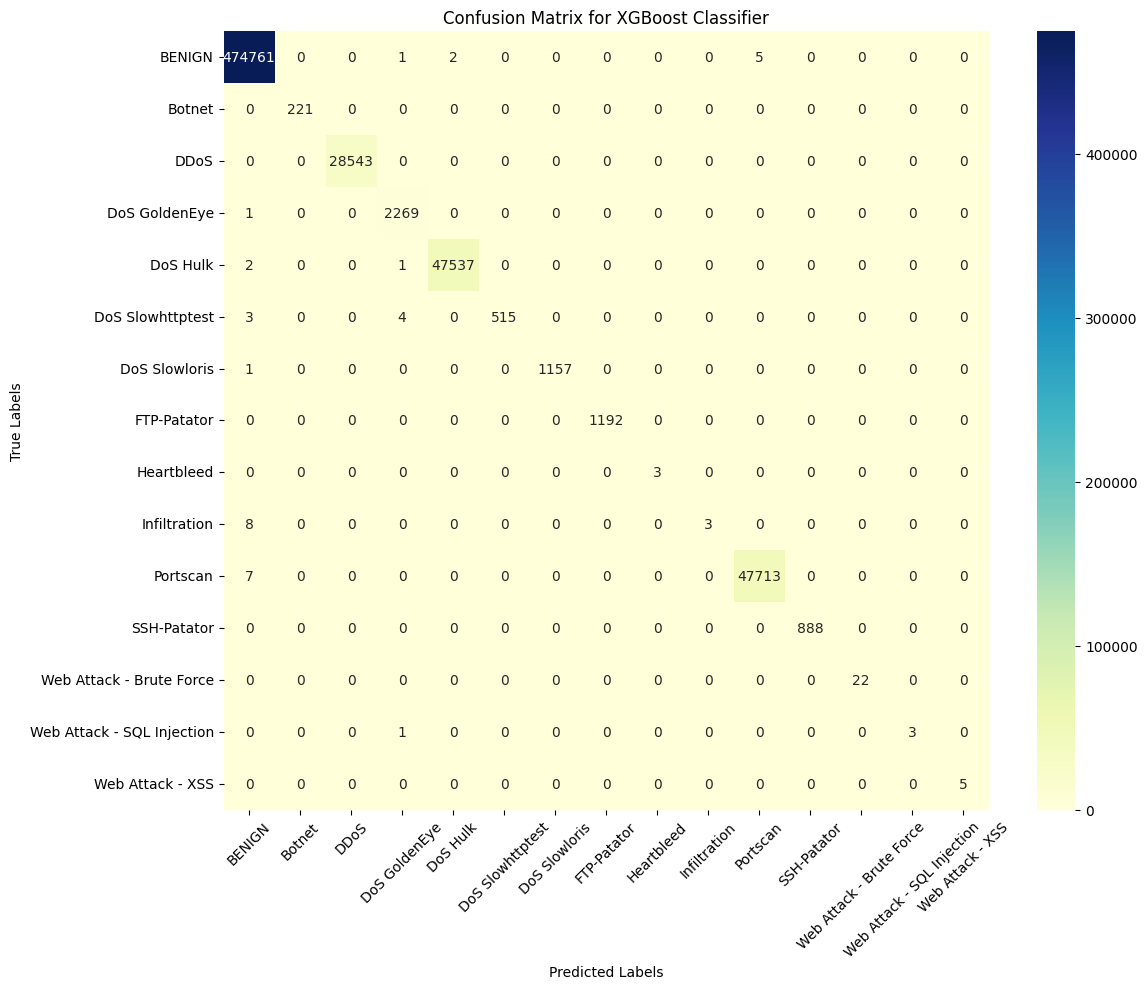

   Macro F1 Score: 0.9518
   Accuracy: 0.9999

🔹 Function 'evaluate_model' executed in 2.0709 seconds
7. Feature Importance Visualization...


<Figure size 1200x800 with 0 Axes>

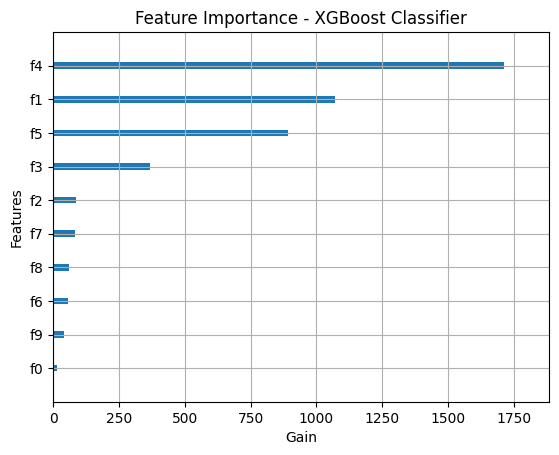

In [4]:

project_path = '/home/tan/Code/finalproject/xgboost-cicids2017'

# Step 1: Load Data
df = load_data(project_path)

# Step 2: Preprocess Data
df, label_encoder, label_dist = preprocess_data(project_path=project_path, full_df=df)

# Step 3: Prepare Data
X_train_scaled, X_test_scaled, y_train, y_test, feature_cols, label_col, scaler = prepare_data(df)

# Further split training data into training and validation sets
print("   Splitting training data into training and validation sets...")
X_train, X_val, y_train, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=42
)
print(f"   Training set size: {X_train.shape[0]} records")
print(f"   Validation set size: {X_val.shape[0]} records\n")

# Step 4: Compute Sample Weights
sample_weights = compute_sample_weights(y_train)

# Step 5: Train Model
num_classes = len(label_encoder.classes_)
model = train_model(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    num_classes=num_classes,
    sample_weights=sample_weights,
    scaler=scaler,
    project_path=project_path
)

# Step 6: Evaluate Model
evaluate_model(
    model=model,
    X_test=X_test_scaled,
    y_test=y_test,
    label_encoder=label_encoder
)

# Step 7: Visualize Feature Importance
visualize_feature_importance(
    model=model,
    feature_names=feature_cols,
    max_features=20
)
